In [49]:
from dolphindb import session
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import sys
import os
import traceback
from scipy.interpolate import CubicSpline
import yfinance as yf
# Import libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import warnings

# Set the style for plotting
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [50]:
def get_data(ticker=None, period='2y', interval='1h'):
    """
    Get stock data from Yahoo Finance
    
    Parameters:
    ticker (str): Ticker symbol (e.g., 'PETR4.SA')
    period (str): Period to download ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
    DataFrame: DataFrame with OHLCV data
    """
    if ticker is None:
        return None
    
    try:
        data = yf.download(ticker, period=period, interval=interval, progress=False)
        
        if data.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Check if we got a MultiIndex DataFrame (happens with group_by='ticker')
        if isinstance(data.columns, pd.MultiIndex):
            print(f"Detected MultiIndex columns, flattening index structure...")
            # If it's just one ticker, we can flatten the columns
            if ticker and ',' not in ticker:
                # Create a flat DataFrame with single-level column names
                flat_data = pd.DataFrame()
                for col_name in ['Open', 'High', 'Low', 'Close', 'Volume']:
                    if (col_name, ticker) in data.columns:
                        flat_data[col_name] = data[(col_name, ticker)]
                    elif col_name in data.columns.get_level_values(0):
                        # Find the right column if ticker doesn't match exactly
                        for second_level in data.columns.get_level_values(1).unique():
                            if (col_name, second_level) in data.columns:
                                flat_data[col_name] = data[(col_name, second_level)]
                                break
                
                # Ensure we have the index (dates/times)
                flat_data.index = data.index
                data = flat_data
            else:
                # For multiple tickers, we'll need a different approach
                # Just flatten column names with a join for now
                data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]
        
        # Convert index to column for further processing
        transformed_data = data.copy()
        transformed_data.reset_index(inplace=True)
        
        # Ensure Datetime column exists and is named correctly
        if 'index' in transformed_data.columns:
            transformed_data.rename(columns={'index': 'Datetime'}, inplace=True)
        elif 'Date' in transformed_data.columns:
            transformed_data.rename(columns={'Date': 'Datetime'}, inplace=True)
            
        transformed_data['Symbol'] = ticker
        
        return transformed_data
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        traceback.print_exc()
        return None
    
def calculate_returns(data, ticker, period, iterations, forecast_days, hours_per_day=7):
    """
    Calculate returns and run Monte Carlo bootstrap simulation on hourly data
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data from yfinance
    ticker (str): Ticker symbol
    period (str): Period for historical data analysis
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average number of trading hours per day, default is 7
    
    Returns:
    dict: Results of the Monte Carlo simulation
    """
    # Copy the dataframe to avoid modifying the original
    asset_df = data.copy()
    
    # Check if we have the right columns and structure
    print(f"DataFrame columns: {asset_df.columns.tolist()}")
    print(f"DataFrame shape: {asset_df.shape}")
    
    # Handle MultiIndex columns if they exist
    if isinstance(asset_df.columns, pd.MultiIndex):
        print("Converting MultiIndex columns to flat structure...")
        # Find the Close column in the MultiIndex
        close_col = None
        for col in asset_df.columns:
            if isinstance(col, tuple) and col[0] == 'Close':
                close_col = col
                break
        
        if close_col:
            # Extract Close price and create a new flat DataFrame
            asset_df = pd.DataFrame({
                'Close': asset_df[close_col],
                'Datetime': asset_df.index if 'Datetime' not in asset_df.columns else asset_df['Datetime']
            })
        else:
            raise ValueError(f"Could not find Close price column in MultiIndex columns: {asset_df.columns.tolist()}")
    
    # Ensure 'Close' exists in the data with proper capitalization
    if 'Close' not in asset_df.columns:
        if 'close' in asset_df.columns:
            asset_df['Close'] = asset_df['close']
        else:
            # Try to find a column that might be the close price
            close_candidates = [col for col in asset_df.columns if 'close' in str(col).lower()]
            if close_candidates:
                asset_df['Close'] = asset_df[close_candidates[0]]
            else:
                raise ValueError(f"No Close price column found in data. Available columns: {asset_df.columns.tolist()}")
    
    # Calculate returns
    asset_df['simple_return'] = asset_df['Close'].pct_change()
    asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Before dropping NaN values, verify column existence
    if 'simple_return' not in asset_df.columns or 'log_return' not in asset_df.columns:
        print("Warning: Return columns not created properly. Column list:", asset_df.columns.tolist())
        # Re-attempt column creation with explicit column names
        asset_df.loc[:, 'simple_return'] = asset_df['Close'].pct_change()
        asset_df.loc[:, 'log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Now it's safe to drop NaN values as we've created the columns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
    
    # Check if we have enough data after cleaning
    if len(asset_df) < 30:  # Arbitrary minimum, adjust as needed
        raise ValueError(f"Not enough data points after cleaning: {len(asset_df)} rows")
    
    # Get empirical distribution of returns
    cdf_values = calculate_cdf_values(asset_df)
    
    # Run Monte Carlo simulation
    # Calculate time_steps as hours_per_day * forecast_days
    time_steps = hours_per_day * forecast_days
    mc_results = mc_bootstrap(
        cdf_values['S0'], 
        cdf_values['interpolated_cdf_values'], 
        cdf_values['sorted_values'], 
        time_steps=time_steps, 
        iterations=iterations,
        hours_per_day=hours_per_day
    )
    
    # Prepare results
    results = {
        'ticker': ticker,
        'last_price': float(cdf_values['S0']),
        'historical_stats': {
            'mean_return': float(asset_df['simple_return'].mean()),
            'std_return': float(asset_df['simple_return'].std()),
            'median_return': float(asset_df['simple_return'].median()),
            'skew': float(asset_df['simple_return'].skew()),
            'kurtosis': float(asset_df['simple_return'].kurtosis())
        },
        'monte_carlo': mc_results
    }
    
    return results, asset_df

def calculate_cdf_values(asset_df):
    """
    Calculate the CDF values for the empirical distribution of log returns
    
    Parameters:
    asset_df (DataFrame): DataFrame with log_return column
    
    Returns:
    dict: CDF values and related statistics
    """
    # Ensure we have log_return column
    if 'log_return' not in asset_df.columns:
        raise ValueError("log_return column not found in data")
    
    # Get unique sorted values of log returns
    sorted_values = np.unique(np.sort(asset_df['log_return']))
    
    # Calculate empirical CDF
    ecdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    
    # Use cubic spline for interpolation
    cs = CubicSpline(sorted_values, ecdf)
    interpolated_cdf_values = cs(sorted_values)

    # Ensure arrays have same length
    min_length = min(len(sorted_values), len(interpolated_cdf_values))
    sorted_values = sorted_values[:min_length]
    interpolated_cdf_values = interpolated_cdf_values[:min_length]
    
    # Calculate survival function (1-CDF)
    sf_interpolated = 1 - interpolated_cdf_values
    
    # Get last price
    S0 = asset_df['Close'].iloc[-1]
    
    # Get median log return
    mu = np.median(asset_df['log_return'])

    return {
        'S0': float(S0),
        'sf_interpolated': sf_interpolated.tolist(),
        'sorted_values': sorted_values.tolist(),
        'interpolated_cdf_values': interpolated_cdf_values.tolist(),
        'mu': float(mu)
    }

def mc_bootstrap(S0, cdf_empirical_interpolated, sorted_values, time_steps, iterations, hours_per_day=7):
    """
    Run Monte Carlo bootstrap simulation with hourly data aggregated to daily paths.
    
    Parameters:
    S0 (float): Starting price
    cdf_empirical_interpolated (list): Interpolated CDF values
    sorted_values (list): Sorted log returns
    time_steps (int): Number of hourly steps to simulate
    iterations (int): Number of Monte Carlo iterations
    hours_per_day (int): Average number of trading hours per day
    
    Returns:
    dict: Simulation results including both hourly and daily paths
    """
    # Convert lists to numpy arrays if they aren't already
    cdf_empirical_interpolated = np.array(cdf_empirical_interpolated)
    sorted_values = np.array(sorted_values)
    
    def _run_simulation(time_steps, iterations):
        # Generate random numbers from uniform distribution
        U = np.random.rand(time_steps, iterations)
        
        # Transform to match empirical distribution using inverse transform sampling
        Z = np.interp(U, cdf_empirical_interpolated, sorted_values)
        
        # Convert log returns to simple returns
        factor = np.exp(Z)
        
        # Hourly paths calculation
        hourly_paths = S0 * np.cumprod(factor, axis=0)
        
        # Reshape to get daily paths (assuming hours_per_day trading hours per day)
        days = time_steps // hours_per_day
        remainder = time_steps % hours_per_day
        
        # Add padding if needed to make the array divisible by hours_per_day
        if remainder > 0:
            padding = hours_per_day - remainder
            # Repeat the last row for padding
            pad = np.tile(hourly_paths[-1, :], (padding, 1))
            hourly_paths = np.vstack([hourly_paths, pad])
            time_steps_adjusted = time_steps + padding
        else:
            time_steps_adjusted = time_steps
        
        # Reshape to (days, hours_per_day, iterations) and get daily closing prices
        reshaped_paths = hourly_paths.reshape(time_steps_adjusted // hours_per_day, hours_per_day, iterations)
        daily_paths = reshaped_paths[:, -1, :] # Take the last hour of each day
        
        # Final values
        arrival_values = daily_paths[-1, :]
        
        return hourly_paths, daily_paths, arrival_values
    
    hourly_paths, daily_paths, arrival_values = _run_simulation(time_steps, iterations)
    
    # Calculate statistics for the final values
    stats = {
        'mean': float(np.mean(arrival_values)),
        'median': float(np.median(arrival_values)),
        'std': float(np.std(arrival_values)),
        'min': float(np.min(arrival_values)),
        'max': float(np.max(arrival_values)),
        'percentiles': {
            '1%': float(np.percentile(arrival_values, 1)),
            '5%': float(np.percentile(arrival_values, 5)),
            '25%': float(np.percentile(arrival_values, 25)),
            '75%': float(np.percentile(arrival_values, 75)),
            '95%': float(np.percentile(arrival_values, 95)),
            '99%': float(np.percentile(arrival_values, 99))
        }
    }
    
    # Save a subset of paths for visualization
    sample_size = max(100, iterations)
    indices = np.random.choice(iterations, sample_size, replace=False)
    
    return {
        'stats': stats,
        'hourly_paths': hourly_paths[:, indices].tolist(),  # Sample paths for plotting
        'daily_paths': daily_paths[:, indices].tolist(),    # Daily paths for plotting
        'path_count': sample_size,
        'days': time_steps // hours_per_day,
        'hours_per_day': hours_per_day
    }

def run_bootstrap(ticker, period_str, iterations, forecast_days, hours_per_day=7):
    """
    Runs the bootstrap simulation for a given ticker
    
    Parameters:
    ticker (str): Ticker symbol
    period_str (str): Period for historical data in yfinance format (e.g., '1y', '2y')
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average trading hours per day
    
    Returns:
    dict: Simulation results
    """
    try:
        # Download data directly via yfinance
        print(f"Downloading data for {ticker} with period={period_str}, interval=1h")
        data = get_data(ticker, period=period_str, interval='1h')
        
        if data is None or len(data) == 0:
            raise Exception(f"Failed to query data for {ticker}")
            
        print(f"Downloaded {len(data)} records")
        
        # Run the bootstrap simulation
        results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
        return results, asset_df, data

    except Exception as e:
        print(f"Error in bootstrap execution: {str(e)}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        raise


def get_best_fit_distribution(results):
    """
    Returns the best fitted distribution and its parameters for the arrival values.
    Parameters:
        results (dict): The results dictionary from the Monte Carlo simulation.
    Returns:
        dict: {'name': best_fit_name, 'params': best_fit_params, 'kstest': ks_stat, 'p_value': p_value}
    """
    import numpy as np
    from scipy import stats
    arrival_values = np.array(results['monte_carlo']['daily_paths'])
    arrival_values = arrival_values[-1, :]  # Take the last day (arrival values)
    distributions = ['norm', 'lognorm', 'gamma', 'beta', 't']
    best_fit = {'name': '', 'kstest': float('inf')}
    for dist_name in distributions:
        try:
            params = getattr(stats, dist_name).fit(arrival_values)
            ks_stat, p_value = stats.kstest(arrival_values, dist_name, params)
            if ks_stat < best_fit['kstest']:
                best_fit = {'name': dist_name, 'kstest': ks_stat, 'p_value': p_value, 'params': params}
        except Exception:
            pass
    print(f"Best fitting distribution: {best_fit['name']}")
    print(f"Parameters: {best_fit['params']}")
    print(f"KS statistic: {best_fit['kstest']:.4f}")
    print(f"p-value: {best_fit['p_value']:.4f}")
    return best_fit

In [51]:
# Visualization of Monte Carlo Paths

# Define parameters
ticker = 'PETR4.SA'  # Brazilian stock - Petrobras
time_frame = '1h'
period = '6mo'
iterations = 500
forecast_days = 3  # Forecast for the next 30 days
hours_per_day = 7  # Based on the data analysis that shows ~7 trading hours per day

# Run the simulation
print(f"Running Monte Carlo bootstrap for {ticker} with {iterations} iterations over {forecast_days} days")
try:
    results, asset_df, raw_data = run_bootstrap(ticker, period, iterations, forecast_days, hours_per_day)
    print("Simulation completed successfully!")
    print(f"Number of Monte Carlo simulations: {iterations}")  # NEW: Print number of simulations
except Exception as e:
    print(f"Error running simulation: {str(e)}")
    raise


def plot_mc_paths(results, raw_data, title=None):
    '''
    Plot Monte Carlo simulation paths and arrival distribution
    '''
    # Extract data from results
    daily_paths = np.array(results['monte_carlo']['daily_paths'])
    hourly_paths = np.array(results['monte_carlo']['hourly_paths'])
    path_count = results['monte_carlo']['path_count']
    print(f"Number of paths made: {path_count}")  # Added print statement
    print(f"Hourly paths shape: {hourly_paths.shape}")  # Print shape of hourly paths
    days = results['monte_carlo']['days']
    hours_per_day = results['monte_carlo']['hours_per_day']
    print(f"Expected hourly paths: {days * hours_per_day} time steps, {path_count} paths")
    print(f"Actual hourly paths: {hourly_paths.shape[0]} time steps, {hourly_paths.shape[1]} paths")
    last_price = results['last_price']
    ticker = results['ticker']
    
    # --- FIX: Ensure all paths start at the current price at day 0 ---
    # Prepend a row of the current price to the beginning of daily_paths
    daily_paths = np.vstack([
        np.full((1, daily_paths.shape[1]), last_price),
        daily_paths
    ])
    # Adjust the time axis accordingly
    time_axis = np.arange(daily_paths.shape[0])
    
    # Get arrival values
    arrival_values = daily_paths[-1, :]
    
    # Calculate percent changes from last price
    percent_changes = (arrival_values - last_price) / last_price * 100
    
    # Find best distribution fit
    from scipy import stats
    distributions = ['norm', 'lognorm', 'gamma', 'beta', 't']
    best_fit = {'name': '', 'kstest': float('inf')}
    
    for dist_name in distributions:
        try:
            # Fit the distribution
            params = getattr(stats, dist_name).fit(arrival_values)
            # Perform Kolmogorov-Smirnov test
            ks_stat, p_value = stats.kstest(arrival_values, dist_name, params)
            
            # Keep track of the best fitting distribution
            if ks_stat < best_fit['kstest']:
                best_fit = {'name': dist_name, 'kstest': ks_stat, 'p_value': p_value, 'params': params}
        except Exception as e:
            print(f"  {dist_name}: Failed to fit - {str(e)}")
    
    # Set up the plot with 2x3 grid for the additional plot
    plt.figure(figsize=(20, 15))
    plt.suptitle(f"Monte Carlo Bootstrap Simulation for {ticker}", fontsize=16)
    
    # 1. Plot Daily Paths
    plt.subplot(2, 3, 1)
    time_axis = np.arange(daily_paths.shape[0])
    
    # Plot each path
    for i in range(path_count):
        plt.plot(time_axis, daily_paths[:, i], linewidth=0.5, alpha=0.3)
    
    # Plot the median path with thicker line
    median_path = np.median(daily_paths, axis=1)
    plt.plot(time_axis, median_path, 'r-', linewidth=2, label='Median Path')
    
    # Plot quantiles (5% and 95%)
    q05 = np.percentile(daily_paths, 5, axis=1)
    q95 = np.percentile(daily_paths, 95, axis=1)
    plt.fill_between(time_axis, q05, q95, color='orange', alpha=0.2, label='90% Confidence')
    
    # Plot the current price at day 0
    plt.scatter(0, last_price, color='black', s=80, zorder=5, label=f'Current Price (Day 0): {last_price:.2f}')  # NEW: Show current price at day 0
    plt.axhline(y=last_price, color='k', linestyle='--', label=f'Last Price: {last_price:.2f}')
    
    plt.title(f"Daily Price Paths (n={path_count})", fontsize=14)
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Plot Arrival Distribution
    plt.subplot(2, 3, 2)
    
    # Plot histogram
    sns.histplot(arrival_values, kde=True, bins=30, color='skyblue')
    
    # Add vertical lines for statistics
    plt.axvline(x=last_price, color='k', linestyle='--', label=f'Last Price: {last_price:.2f}')
    plt.axvline(x=results['monte_carlo']['stats']['mean'], color='r', linestyle='-', label=f"Mean: {results['monte_carlo']['stats']['mean']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['median'], color='g', linestyle=':', label=f"Median: {results['monte_carlo']['stats']['median']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['percentiles']['5%'], color='orange', linestyle='-.', label=f"5%: {results['monte_carlo']['stats']['percentiles']['5%']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['percentiles']['95%'], color='orange', linestyle='-.', label=f"95%: {results['monte_carlo']['stats']['percentiles']['95%']:.2f}")
    
    plt.title(f"Arrival Distribution (Day {days})", fontsize=14)
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Plot Log Returns Distribution
    plt.subplot(2, 3, 3)
    log_returns = asset_df['log_return']
    
    # Plot histogram
    sns.histplot(log_returns, kde=True, bins=50, color='lightgreen')
    
    # Add statistics
    plt.axvline(x=log_returns.mean(), color='r', linestyle='-', label=f"Mean: {log_returns.mean():.5f}")
    plt.axvline(x=log_returns.median(), color='g', linestyle=':', label=f"Median: {log_returns.median():.5f}")
    plt.axvline(x=0, color='k', linestyle='--', label='Zero')
    
    plt.title("Log Returns Distribution", fontsize=14)
    plt.xlabel("Log Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Fit a distribution to arrival values - percent changes
    plt.subplot(2, 3, 4)
    
    # Plot histogram of percent changes
    sns.histplot(percent_changes, kde=True, bins=30, color='lightcoral')
    
    # Calculate statistics
    mean_pct = np.mean(percent_changes)
    median_pct = np.median(percent_changes)
    std_pct = np.std(percent_changes)
    skew_pct = results['monte_carlo']['stats']['mean'] - results['monte_carlo']['stats']['median']
    
    # Add vertical lines for statistics
    plt.axvline(x=0, color='k', linestyle='--', label='No Change (0%)')
    plt.axvline(x=mean_pct, color='r', linestyle='-', label=f"Mean: {mean_pct:.2f}%")
    plt.axvline(x=median_pct, color='g', linestyle=':', label=f"Median: {median_pct:.2f}%")
    
    # Try to fit a normal distribution
    x = np.linspace(np.min(percent_changes), np.max(percent_changes), 100)
    normal_pdf = stats.norm.pdf(x, mean_pct, std_pct)
    plt.plot(x, normal_pdf * len(percent_changes) * (x.max() - x.min()) / 30, 'b--', linewidth=2, label='Normal Fit')
    
    # Add text with distribution statistics
    info_text = (f"Mean: {mean_pct:.2f}%\n"
                f"Median: {median_pct:.2f}%\n"
                f"Std Dev: {std_pct:.2f}%\n"
                f"Skew: {skew_pct:.5f}")
    
    plt.annotate(info_text, xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                va='top', ha='left')
    
    plt.title("Arrival % Change Distribution with Normal Fit", fontsize=14)
    plt.xlabel("Percent Change from Current Price (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. NEW: Plot the best fitting distribution
    plt.subplot(2, 3, 5)
    
    # Histogram of arrival values
    sns.histplot(arrival_values, kde=True, stat='density', label='Empirical', bins=30, color='skyblue')
    
    # Generate x values for the PDF
    x = np.linspace(min(arrival_values), max(arrival_values), 1000)
    
    # Get the PDF of the best fitting distribution
    if best_fit['name']:
        best_dist = getattr(stats, best_fit['name'])
        try:
            pdf = best_dist.pdf(x, *best_fit['params'][:-2], loc=best_fit['params'][-2], scale=best_fit['params'][-1])
            plt.plot(x, pdf, 'r-', linewidth=2, label=f"{best_fit['name']} fit")
            
            # Add statistical test info
            fit_info = (f"Best fit: {best_fit['name']}\n"
                        f"KS stat: {best_fit['kstest']:.4f}\n"
                        f"p-value: {best_fit['p_value']:.4f}")
            
            plt.annotate(fit_info, xy=(0.05, 0.95), xycoords='axes fraction',
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                        va='top', ha='left')
        except Exception as e:
            print(f"Error plotting PDF: {str(e)}")
    
    plt.title(f"Arrival Distribution with {best_fit['name']} Fit", fontsize=14)
    plt.xlabel("Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Display fitting statistics for all distributions
    plt.subplot(2, 3, 6)
    
    # Create a table to show all distribution fitting results
    dist_stats = []
    dist_names = []
    ks_stats = []
    p_values = []
    
    for dist_name in distributions:
        try:
            params = getattr(stats, dist_name).fit(arrival_values)
            ks_stat, p_value = stats.kstest(arrival_values, dist_name, params)
            dist_names.append(dist_name)
            ks_stats.append(ks_stat)
            p_values.append(p_value)
        except Exception:
            pass
    
    # Create a bar plot for KS statistics (lower is better)
    plt.barh(dist_names, ks_stats, color='skyblue')
    plt.axvline(x=0.05, color='r', linestyle='--', label='Critical Value (0.05)')
    plt.title("Distribution Goodness-of-Fit (KS Statistic)", fontsize=14)
    plt.xlabel("Kolmogorov-Smirnov Statistic (lower is better)")
    plt.ylabel("Distribution")
    plt.grid(True, alpha=0.3)
    
    # Add p-values as text
    for i, (name, ks, p) in enumerate(zip(dist_names, ks_stats, p_values)):
        plt.text(ks + 0.01, i, f"p={p:.4f}", va='center')
    
    # Adjust layout and display plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Also print the distribution fitting info to console
    print("\nFitting distributions to arrival prices:")
    for name, ks, p in zip(dist_names, ks_stats, p_values):
        print(f"  {name}: KS={ks:.4f}, p-value={p:.4f}")
    
    print(f"\nBest fitting distribution: {best_fit['name']}")
    print(f"  KS statistic: {best_fit['kstest']:.4f}")
    print(f"  p-value: {best_fit['p_value']:.4f}")
    
    # Return key statistics for further analysis
    return {
        'arrival_values': arrival_values,
        'percent_changes': percent_changes,
        'mean_pct': mean_pct,
        'median_pct': median_pct,
        'std_pct': std_pct,
        'skew': skew_pct,
        'best_fit': best_fit
    }

Running Monte Carlo bootstrap for PETR4.SA with 500 iterations over 3 days
Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)
Simulation completed successfully!
Number of Monte Carlo simulations: 500
Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)
Simulation completed successfully!
Number of Monte Carlo simulations: 500


Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)
Number of paths made: 500
Hourly paths shape: (35, 500)
Expected hourly paths: 35 time steps, 500 paths
Actual hourly paths: 35 time steps, 500 paths
Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)
Number of paths made: 500
Hourly paths shape: (35, 500)
Expected hourly paths: 35 time steps, 500 paths
Actual hourly paths: 35 time steps, 500 paths


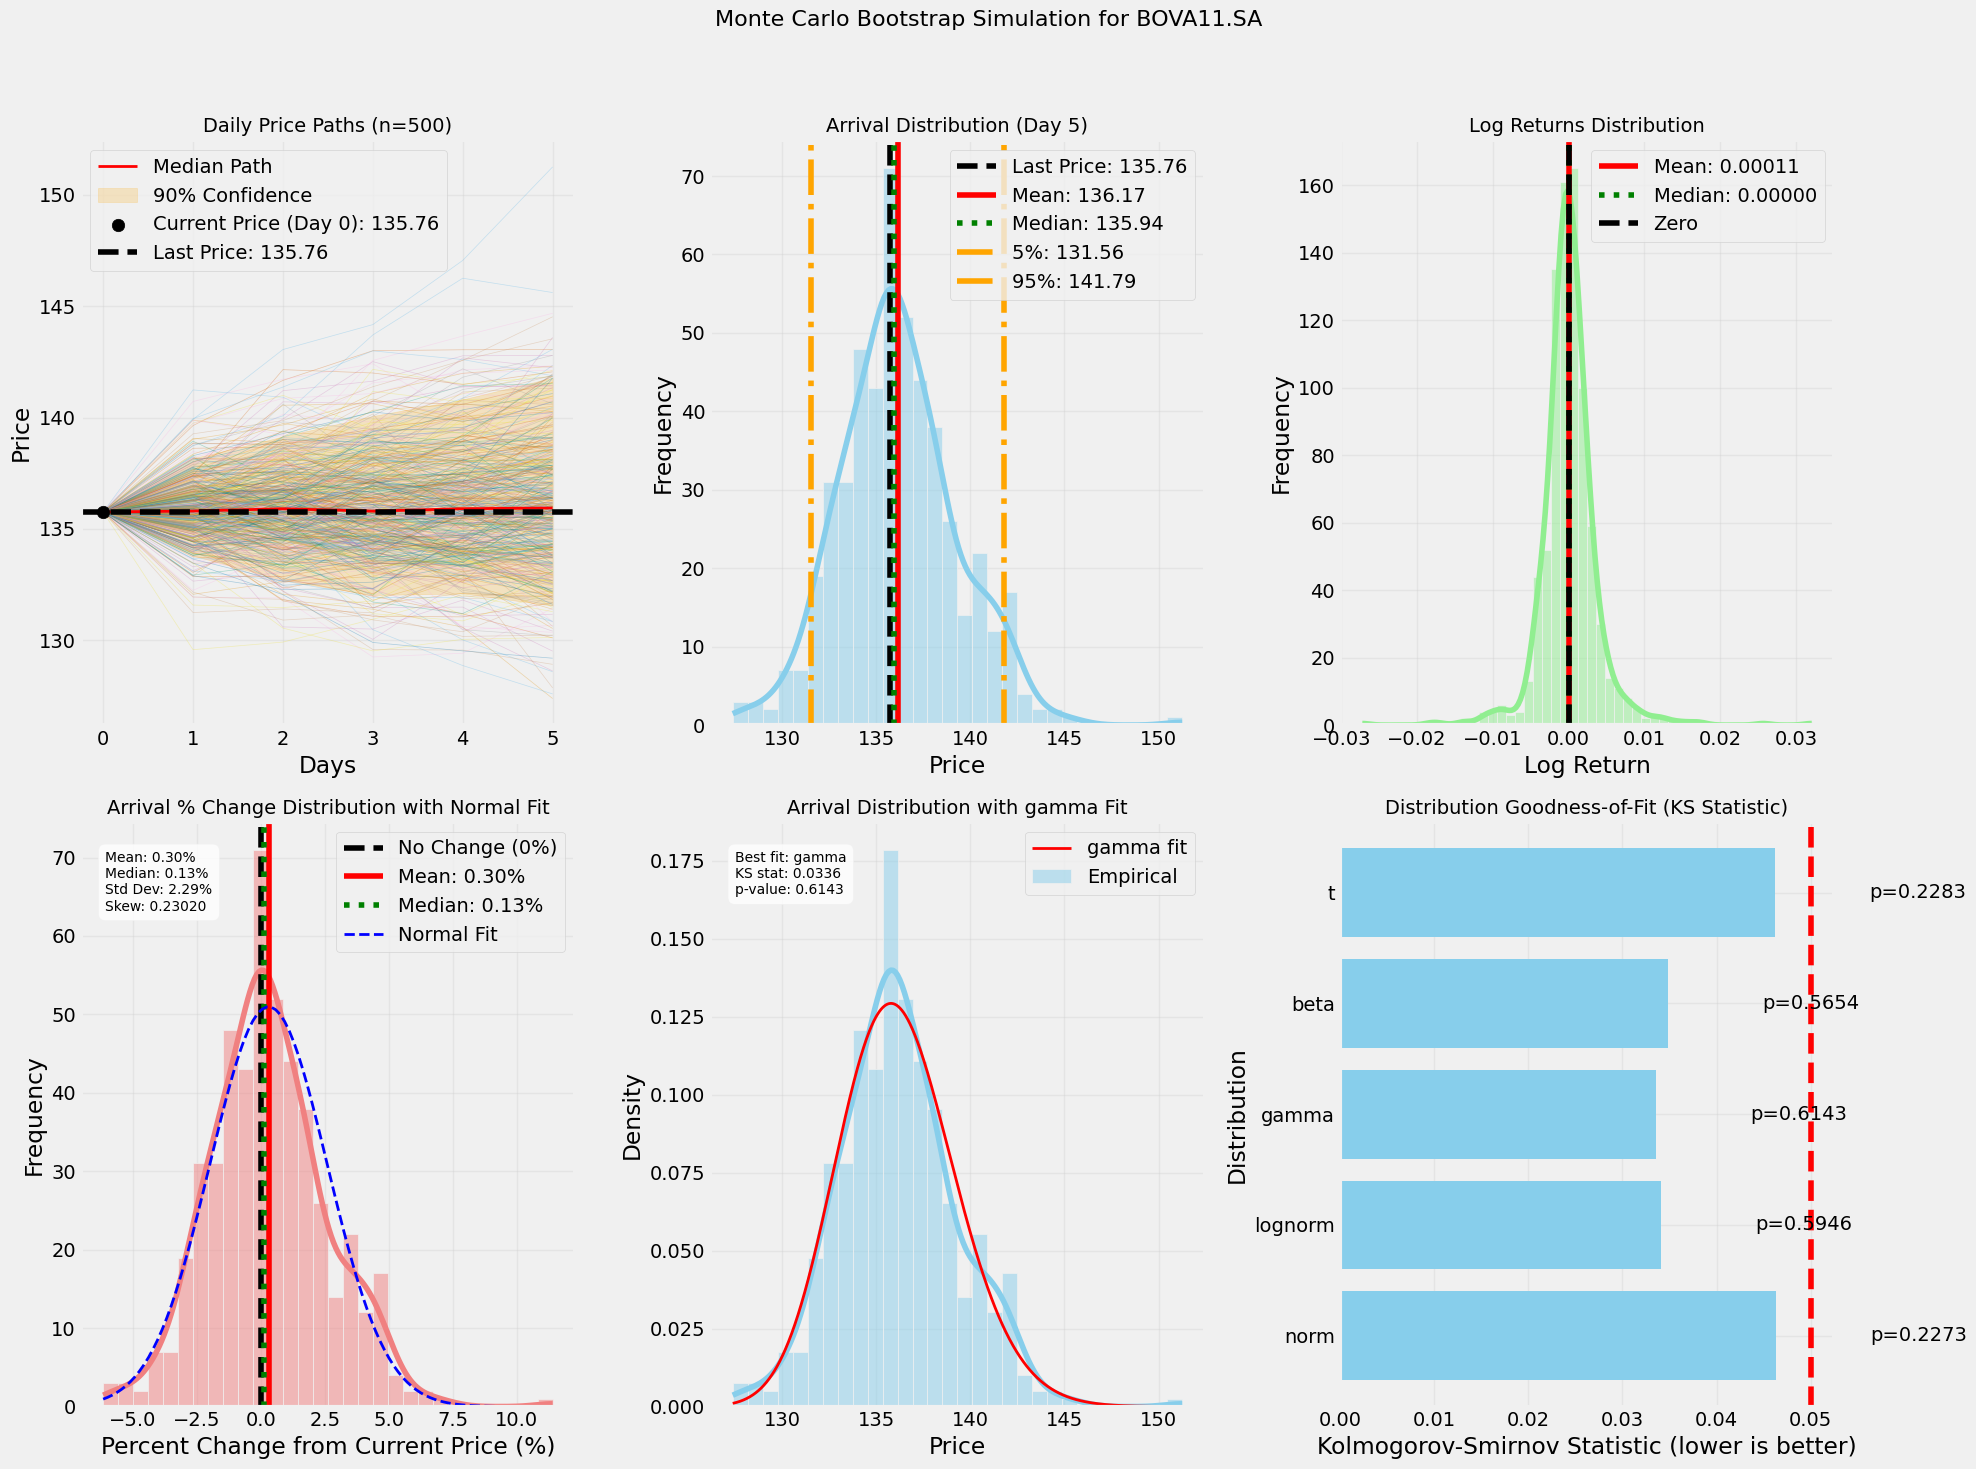


Fitting distributions to arrival prices:
  norm: KS=0.0463, p-value=0.2273
  lognorm: KS=0.0341, p-value=0.5946
  gamma: KS=0.0336, p-value=0.6143
  beta: KS=0.0349, p-value=0.5654
  t: KS=0.0462, p-value=0.2283

Best fitting distribution: gamma
  KS statistic: 0.0336
  p-value: 0.6143


In [52]:
# Basic usage
ticker = "BOVA11.SA"  # bbdas3
iterations = 500
forecast_days = 5
results, asset_df, raw_data = run_bootstrap(ticker, "6mo", iterations, forecast_days)

# Visualize results
plot_stats = plot_mc_paths(results, raw_data)


In [53]:
results, asset_df, raw_data = run_bootstrap(ticker, "6mo", iterations, forecast_days)

Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)
Detected MultiIndex columns, flattening index structure...
Downloaded 838 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (838, 7)


In [54]:
get_best_fit_distribution(results)

Best fitting distribution: t
Parameters: (12.236320698585452, 136.22747080428823, 3.168772937897071)
KS statistic: 0.0236
p-value: 0.9379


{'name': 't',
 'kstest': 0.023560058344132162,
 'p_value': 0.9379415873829998,
 'params': (12.236320698585452, 136.22747080428823, 3.168772937897071)}